**In this notebook, we are going to look at the relationship between the internal parameters of the simulation and the rule obtained by the anchors that a navigation will be safe if the mean of the persistent entropy time series is greater than 2.68. The aim of this is to narrow down the parameters of the simulation a priori, so that we can identify that the navigation will be safe (without collisions) or not, thanks to its relation with the mentioned rule.**

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import os

import warnings as w
w.filterwarnings('ignore')

import seaborn as sns
from scipy.stats import mannwhitneyu

Load the data, and set up a feature regarding to the number of collisions and another one regarding the obtained rule.

In [4]:
data_path = "simulationVictorTopological/"
output="output"
output2="meanEntropy>2.68"
data = pd.read_csv(data_path+"dataset.csv")
data[output] = data["NumberOfCollisions"].apply(lambda x: 1 if x > 0 else x)
data = data.drop(["NumberOfCollisions"],axis = 1)
data[output2] = data["meanEntropy"].apply(lambda x: 1 if x > 2.68 else 0)
cn = np.array(["Unsafety","Safety"])

## Exploratory analisis

In [5]:
data

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output,meanEntropy>2.68
0,0.071519,0.548814,0.592845,2.695124,2.69170,0.026651,0.039825,0,1
1,0.072032,0.417022,0.997185,2.689001,2.69020,0.019571,0.025725,1,1
2,0.002593,0.435995,0.185082,2.640576,2.64350,0.035025,0.043500,1,0
3,0.070815,0.550798,0.070725,2.701690,2.70040,0.026586,0.033800,0,1
4,0.054723,0.967030,0.900621,2.667703,2.66825,0.027199,0.043925,1,0
...,...,...,...,...,...,...,...,...,...
9995,0.022222,0.436016,0.889067,2.648257,2.64870,0.037336,0.041700,1,0
9996,0.039925,0.669633,0.255284,2.688051,2.68850,0.028443,0.037425,0,1
9997,0.059391,0.041756,0.185140,2.673935,2.67550,0.040172,0.059475,0,0
9998,0.083177,0.193544,0.624583,2.690693,2.68960,0.026939,0.038225,1,1


In [7]:
print(pd.value_counts(data[output]))
print(pd.value_counts(data[output2])) 

output
0    5557
1    4443
Name: count, dtype: int64
meanEntropy>2.68
0    5683
1    4317
Name: count, dtype: int64


If we study the correlation between these parameters and the average entropy, we can see that the safety_margin and tau correlate with the average entropy, so that we can probably narrow down these parameters so that navigation complies with this ‘safe’ navigation rule.

<Axes: >

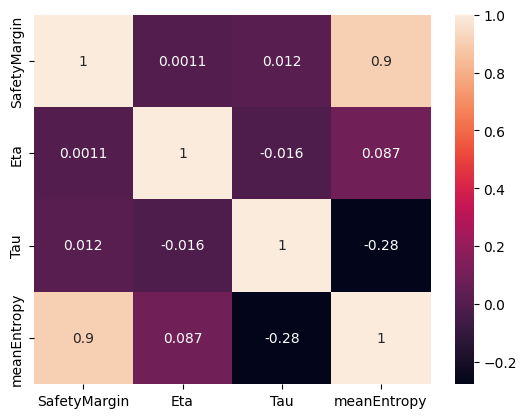

In [8]:
# Correlación entre parámetros y media
correlation_matrix = data[['SafetyMargin', 'Eta', 'Tau', 'meanEntropy']].corr()
sns.heatmap(correlation_matrix, annot=True)


The same but with a point cloud, in the tau and safety_margin graph, we can easily identify how there is an area where the majority of safe simulations are distributed and on the other hand, unsafe navigations. This graph tells us enough.

It means, that with the tau and safety margin we seem to be able to keep a simulation within limits.

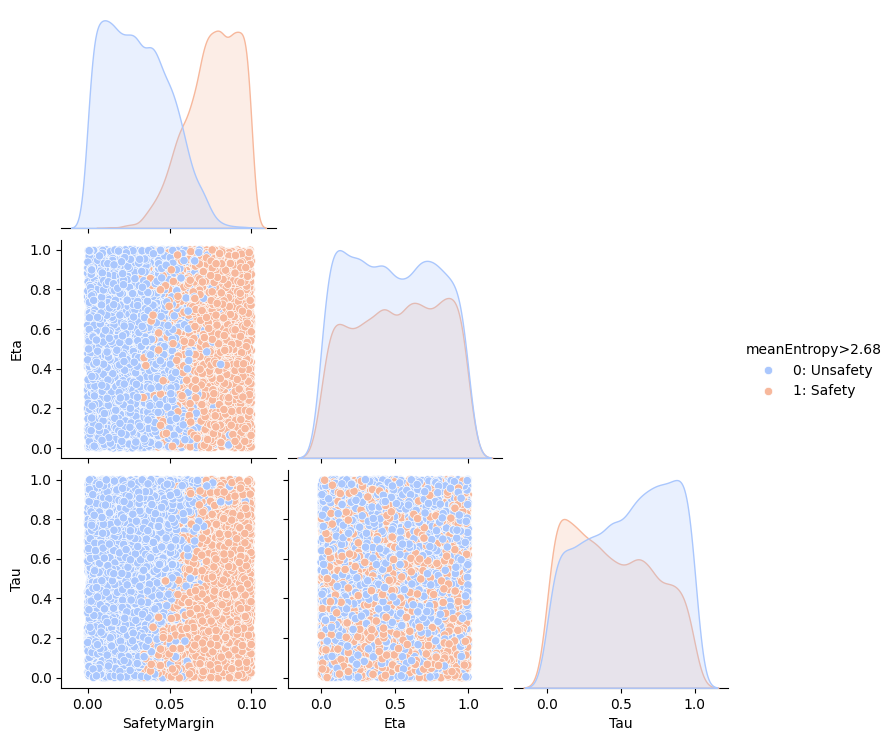

In [20]:
pairplot = sns.pairplot(data, vars=['SafetyMargin', 'Eta','Tau'], hue=output2, palette='coolwarm',corner=True)
new_labels = ['0: Unsafety', '1: Safety']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

We see the difference of the parameters regarding the two sides of the rules. The safety_margin is the one that is more different for each part of the rule.

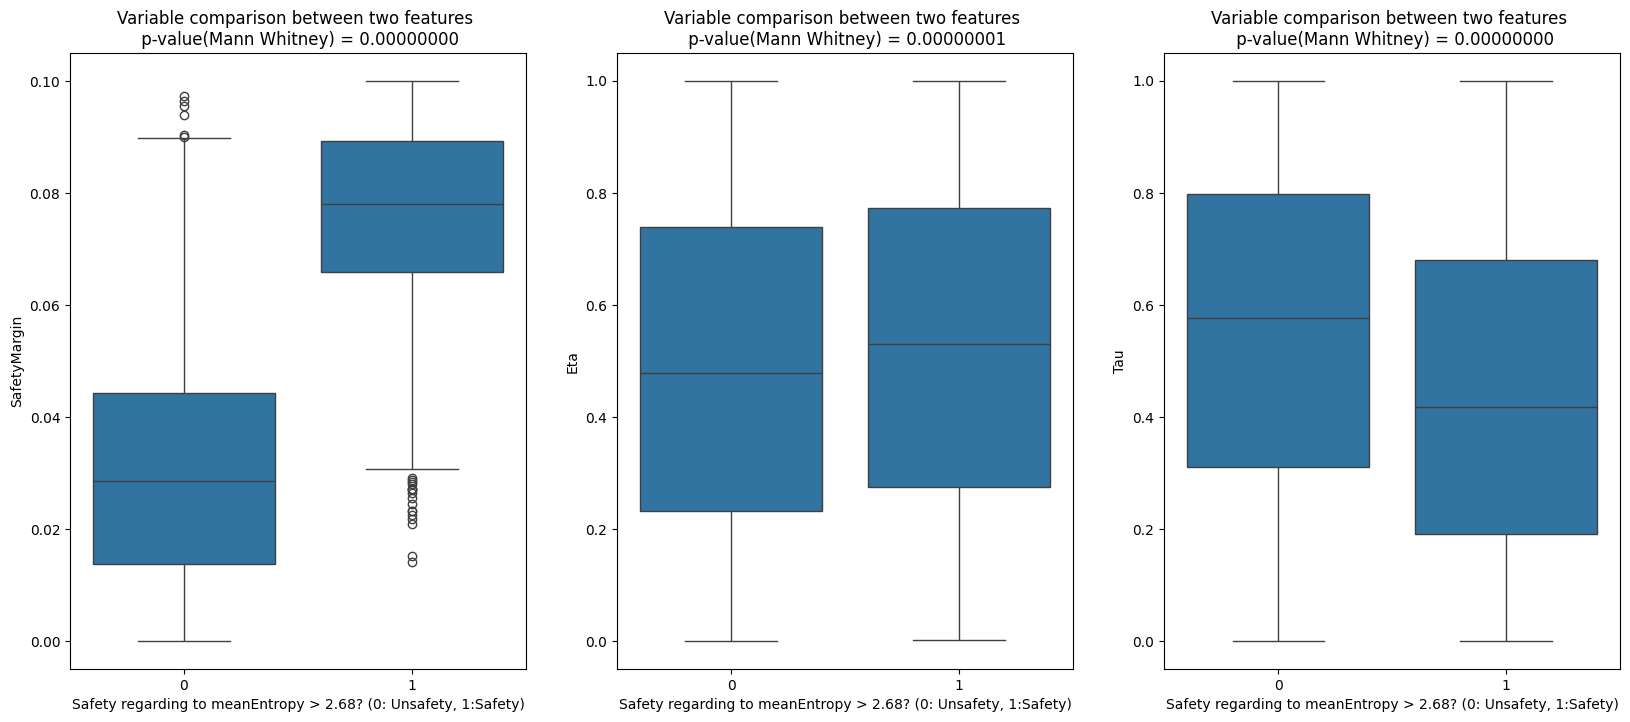

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['SafetyMargin', 'Eta', 'Tau']):
    Cvalues = data[data[output2] == 1][i].values
    NCvalues = data[data[output2] == 0][i].values
    u_stat, p_value = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x=output2, y=i, data=data)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.8f}')
    plt.xlabel("Safety regarding to meanEntropy > 2.68? (0: Unsafety, 1:Safety)")
    plt.ylabel(i)

plt.show()

Same with histograms

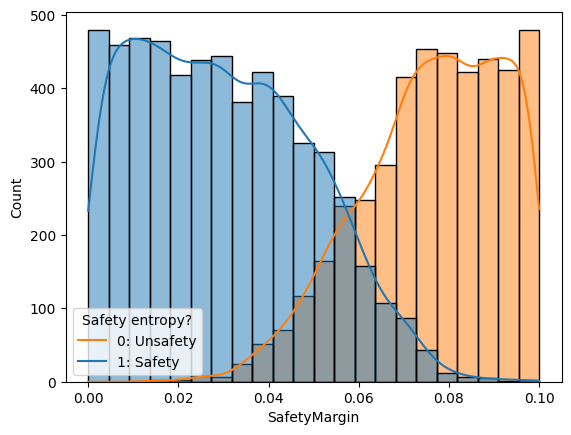

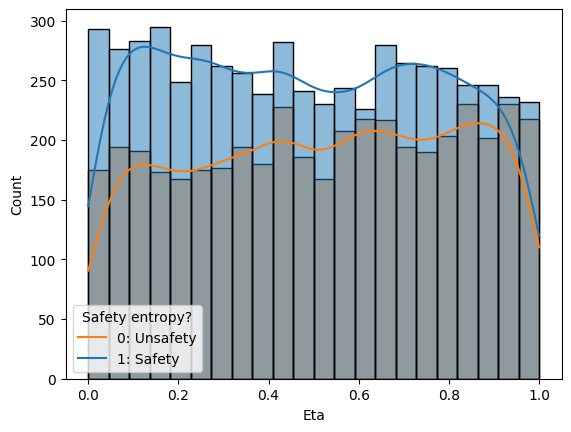

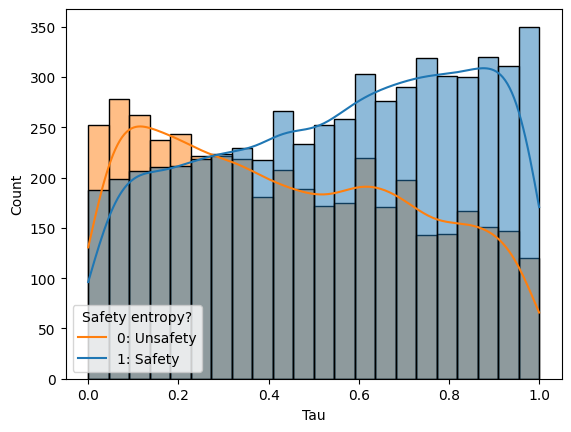

In [12]:
sns.histplot(data=data, x='SafetyMargin', hue=output2, kde=True)
plt.legend(title='Safety entropy?', loc='lower left', labels=['0: Unsafety', '1: Safety'])
plt.show()
sns.histplot(data=data, x='Eta', hue=output2, kde=True)
plt.legend(title='Safety entropy?', loc='lower left', labels=['0: Unsafety', '1: Safety'])
plt.show()
sns.histplot(data=data, x='Tau', hue=output2, kde=True)
plt.legend(title='Safety entropy?', loc='lower left', labels=['0: Unsafety', '1: Safety'])
plt.show()

Next we will generate easy-to-interpret models in order to detect parameter rules that keep the simulations within the safe part. We will test the logistic regression model, and decision dtrees.

In [13]:
# Define predictive features and objective feature(safety or not safety according to the rule)
X = data[['SafetyMargin', 'Eta', 'Tau']]
y = data[output2]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Regresion logistica

Accuracy: 0.923


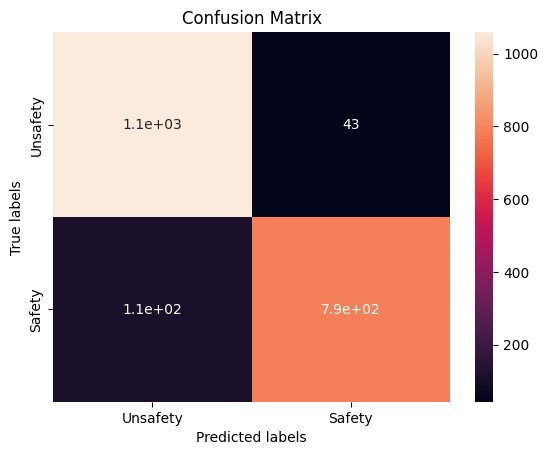

In [14]:
# Train model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluating performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ax=plt.subplot()
sns.heatmap(conf_matrix, annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Unsafety', 'Safety']); ax.yaxis.set_ticklabels(['Unsafety', 'Safety']);
plt.show()

## Decision trees, Random Forest

Accuracy: 0.912


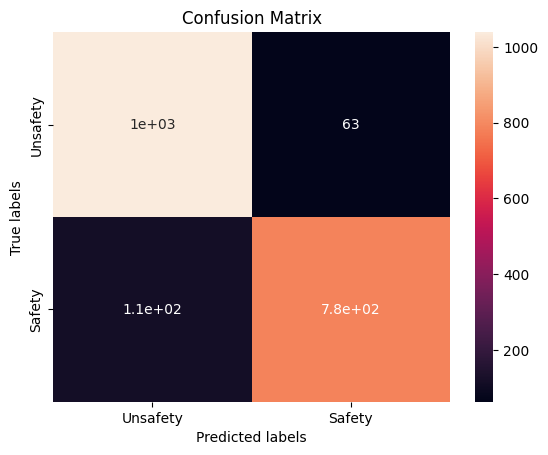

In [83]:
# Train model
dtree = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluating performance
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
print(f'Accuracy: {accuracy_dtree}')

# Confusion matrix
conf_matrix_dtree = confusion_matrix(y_test, y_pred_dtree)
ax=plt.subplot()
sns.heatmap(conf_matrix_dtree, annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Unsafety', 'Safety']); ax.yaxis.set_ticklabels(['Unsafety', 'Safety']);
plt.show()

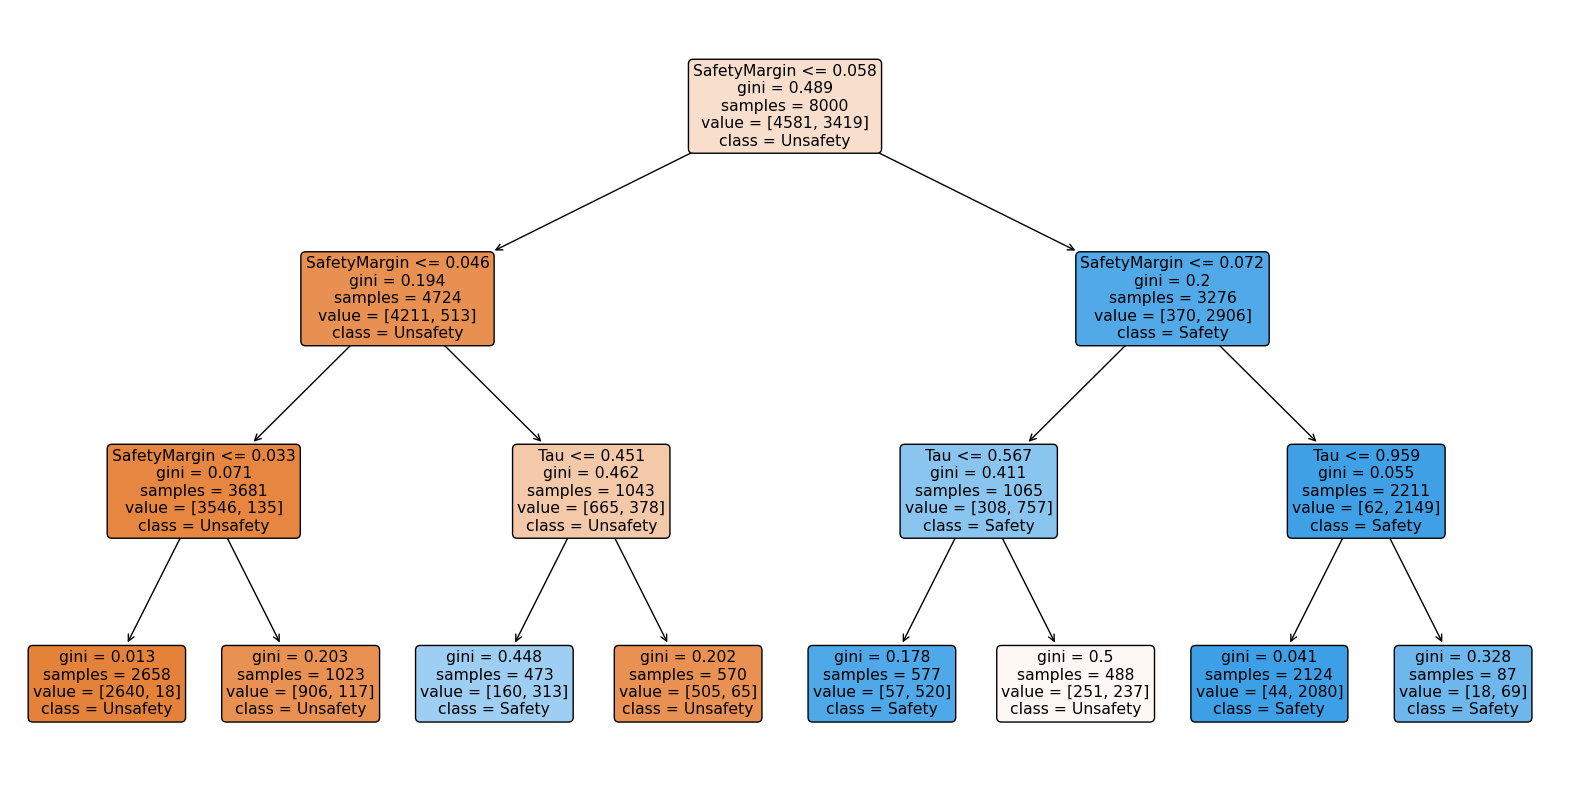

In [86]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtree, filled=True, rounded=True,feature_names=['SafetyMargin','Eta', 'Tau'],class_names=["Unsafety","Safety"])
plt.show()

We obtain a fairly high accuracy, and we can also observe that the characteristics used are TAU and safetymargin.

Accuracy: 0.921


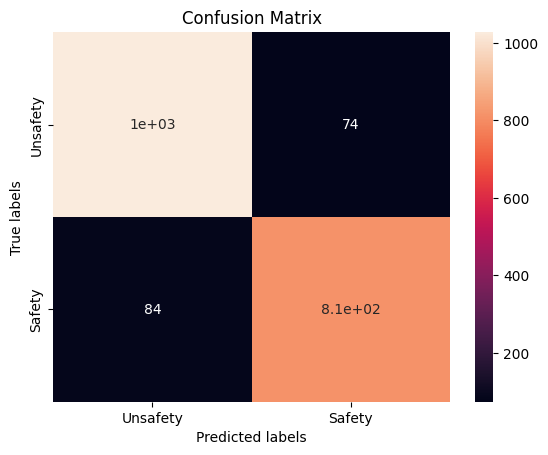

In [87]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el bosque aleatorio
forest = RandomForestClassifier(n_estimators=100,max_depth=4, random_state=42)
forest.fit(X_train, y_train)

# Predicciones
y_pred_forest = forest.predict(X_test)

# Evaluar el rendimiento
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f'Accuracy: {accuracy_forest}')

# Matriz de confusión
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)
ax=plt.subplot()
sns.heatmap(conf_matrix_forest, annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Unsafety', 'Safety']); ax.yaxis.set_ticklabels(['Unsafety', 'Safety']);
plt.show()

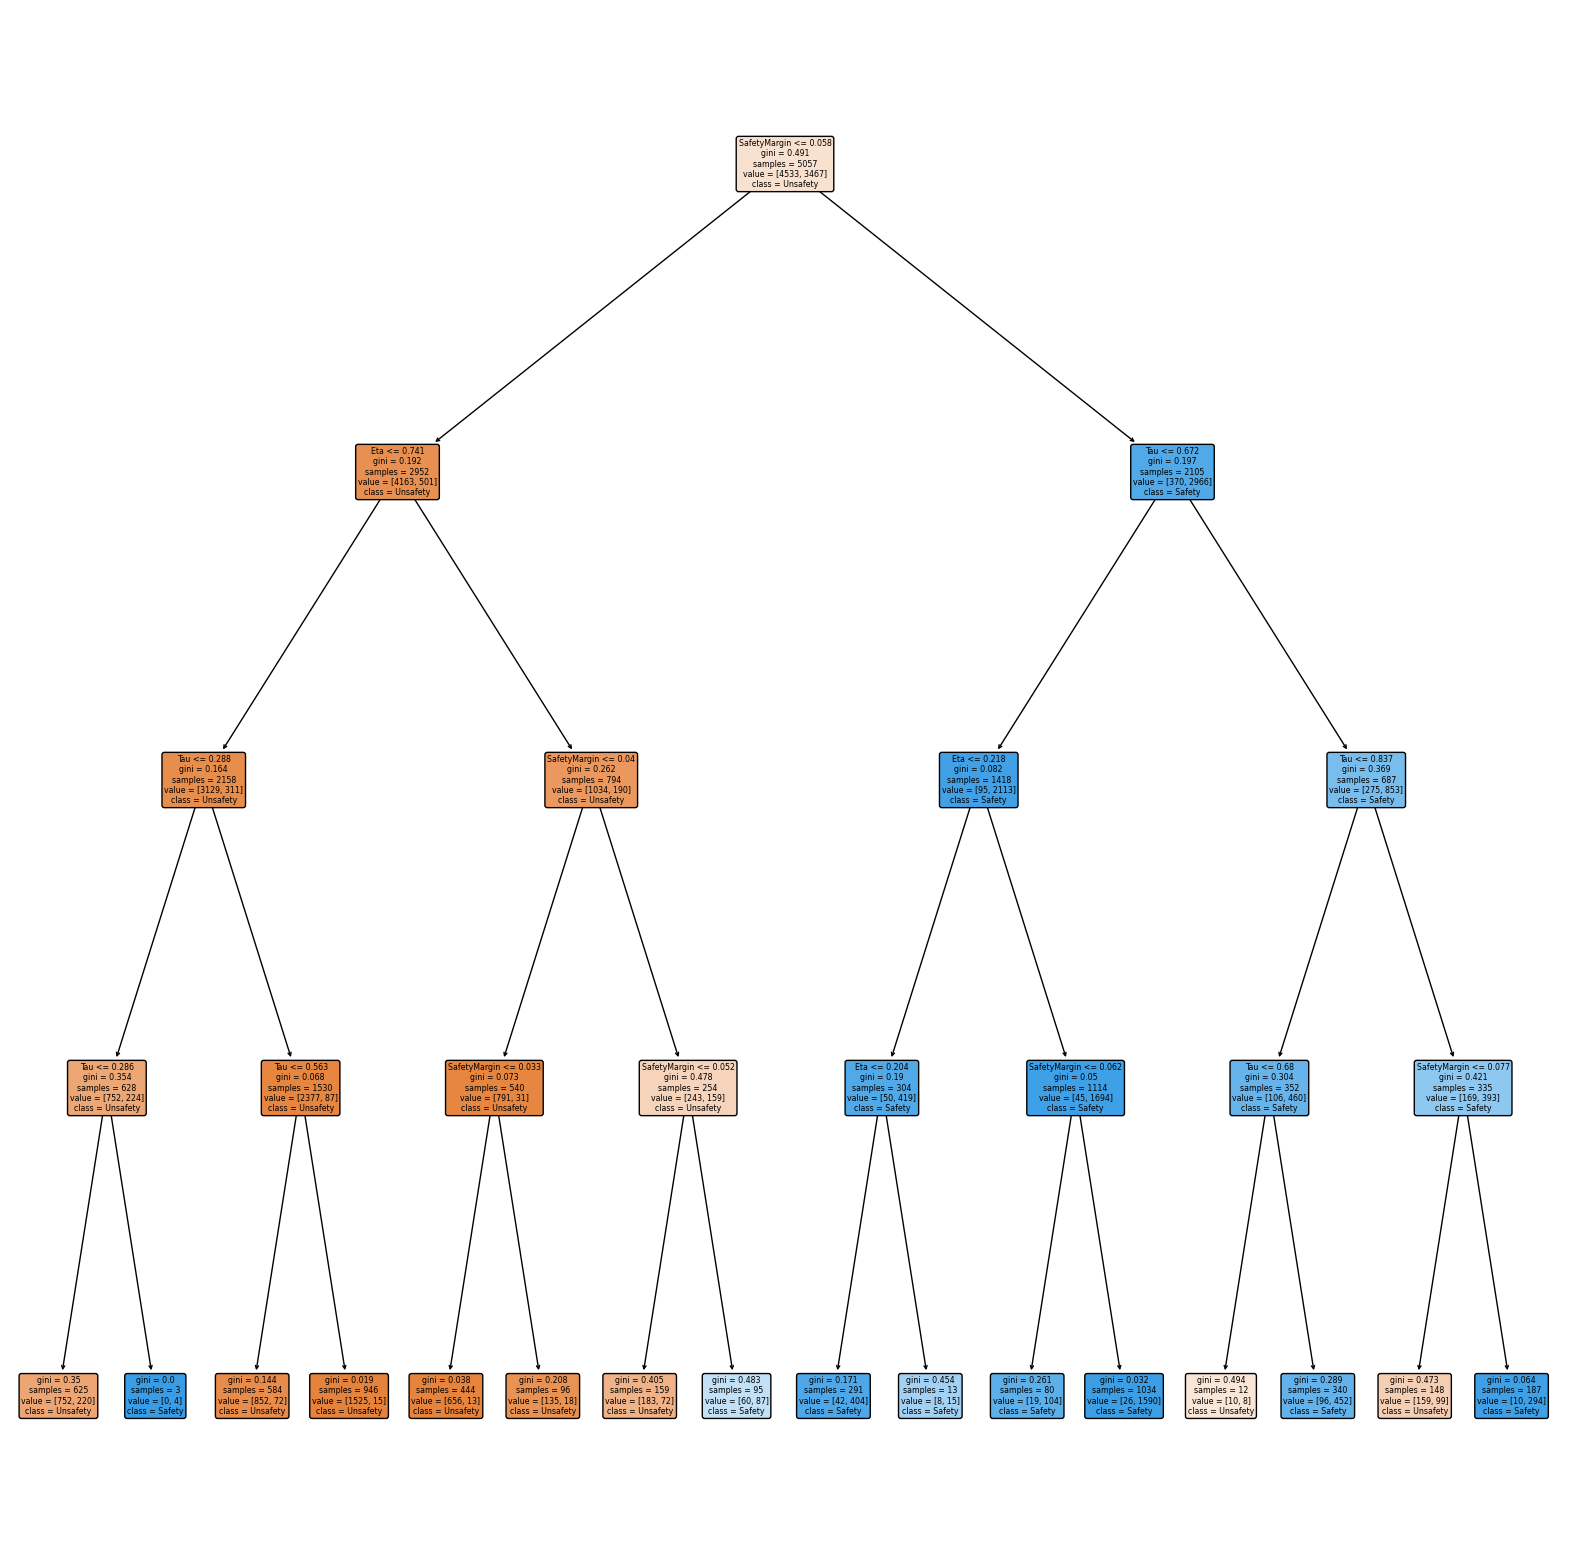

In [88]:
plt.figure(figsize=(20,20))
tree.plot_tree(forest.estimators_[0], filled=True, rounded=True,feature_names=['SafetyMargin','Eta', 'Tau'],class_names=["Unsafety","Safety"])
plt.show()

In [89]:
# Informe de clasificación para cada modelo
print("Logistic Regression:\n", classification_report(y_test, y_pred))
print("Decision dtree:\n", classification_report(y_test, y_pred_dtree))
print("Random Forest:\n", classification_report(y_test, y_pred_forest))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1102
           1       0.95      0.88      0.91       898

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Decision dtree:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      1102
           1       0.93      0.87      0.90       898

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Random Forest:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      1102
           1       0.92      0.91      0.91       898

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       